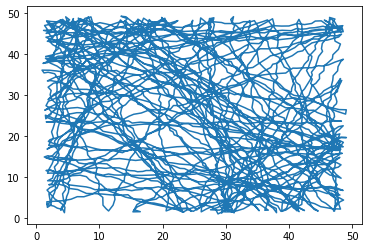

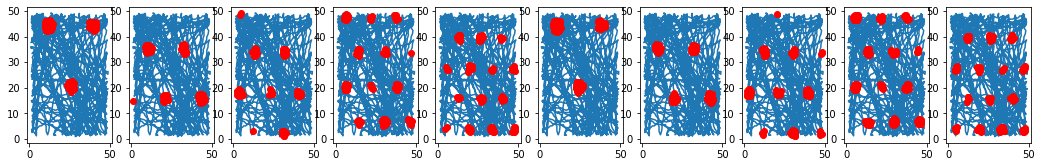

In [2]:
### Guanella 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage.filters as filt
arena_size = 50

arenaX = [0,arena_size]
arenaY = [0,arena_size]

## Initial position
Txx = [arenaX[1]/2]
Tyy = [arenaY[1]/2]

def conv(ang):
    x = np.cos(np.radians(ang)) 
    y = np.sin(np.radians(ang)) 
    return x , y

def random_navigation(length):
    thetaList = []

    theta = 90
    counter = 0
    lenght_counter = 0
    for i in range(length):
        lenght_counter += 1

        prevTheta = np.copy(theta)

        if( Txx[-1]<2 ): theta = np.random.randint(-85,85)

        if( Txx[-1]>arena_size-2 ): theta = np.random.randint(95,260)

        if( Tyy[-1]<2 ): theta = np.random.randint(10,170)

        if( Tyy[-1]>arena_size-2 ): theta = np.random.randint(190,350)


        Txx.append( Txx[-1]+conv(theta)[0] + np.random.uniform(-0.5,0.5) )
        Tyy.append( Tyy[-1]+conv(theta)[1] + np.random.uniform(-0.5,0.5)  )

        cx = abs( Txx[-1] - Txx[-2]  )
        cy = abs( Tyy[-1] - Tyy[-2]  )
        h = np.sqrt( cx**2 + cy**2  )
        counter+=h

        if(theta != prevTheta or i == length-1):
            thetaList.append( [prevTheta, conv(prevTheta)[0], conv(prevTheta)[1], counter]  )
            counter = 0
    
    plt.plot(Txx,Tyy, '-')
    plt.show()


random_navigation(5000)

Txx = np.array(Txx)
Tyy = np.array(Tyy)

class Grid():
    def __init__(self, gain):
        
        self.mm = 20
        self.nn = 20
        self.TAO = 0.9
        self.II = 0.3
        self.SIGMA = 0.24
        self.SIGMA2 = self.SIGMA**2
        self.TT = 0.05
        self.grid_gain = gain
        self.grid_layers = len(self.grid_gain)  
        self.grid_activity = np.random.uniform(0,1,(self.mm,self.nn,self.grid_layers))  
        self.distTri = self.buildTopology(self.mm,self.nn)


    def update(self, speedVector):

        self.speedVector = speedVector
        
        grid_ActTemp = []
        for jj in range(0,self.grid_layers):
            rrr = self.grid_gain[jj]*np.exp(1j*0)
            matWeights = self.updateWeight(self.distTri,rrr)
            activityVect = np.ravel(self.grid_activity[:,:,jj])
            activityVect = self.Bfunc(activityVect, matWeights)
            activityTemp = activityVect.reshape(self.mm,self.nn)
            activityTemp += self.TAO *( activityTemp/np.mean(activityTemp) - activityTemp)
            activityTemp[activityTemp<0] = 0

            self.grid_activity[:,:,jj] = (activityTemp-np.min(activityTemp))/(  np.max(activityTemp)-np.min(activityTemp)) * 30  ##Eq 2
                        

    def buildTopology(self,mm,nn):  # Build connectivity matrix     ### Eq 4
        mmm = (np.arange(mm)+(0.5/mm))/mm
        nnn = ((np.arange(nn)+(0.5/nn))/nn)*np.sqrt(3)/2
        xx,yy = np.meshgrid(mmm, nnn)
        posv = xx+1j * yy
        Sdist = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]      
        xx,yy = np.meshgrid( np.ravel(posv) , np.ravel(posv) )
        distmat = xx-yy
        for ii in range(len(Sdist)):
            aaa1 = abs(distmat)
            rrr = xx-yy + Sdist[ii]
            aaa2 = abs(rrr)
            iii = np.where(aaa2<aaa1)
            distmat[iii] = rrr[iii]
        return distmat.transpose()

    def updateWeight(self,topology,rrr): # Slight update on weights based on speed vector.
        matWeights = self.II * np.exp((-abs(topology-rrr*self.speedVector)**2)/self.SIGMA2) - self.TT   ## Eq 3
        return matWeights

    def Bfunc(self,activity, matWeights):  ## Eq 1
        activity += np.dot(activity,matWeights)
        return activity
# this produces grid cells with different scales. Change the list to just one scale for one module
scale = [0.04,0.05,0.06,0.07,0.08]
grid = Grid(scale)

log_grid_cells = []
for i in range(1,Txx.size):

    speedVector = (Txx[i]-Txx[i-1])+1j*(Tyy[i]-Tyy[i-1])

    grid.update(speedVector)
    log_grid_cells.append( grid.grid_activity.flatten()  )
    
log_grid_cells = np.array(log_grid_cells)
xx = np.copy(Txx[1:])
yy = np.copy(Tyy[1:])
dv_levels = [0,5,10]
plt.figure(figsize=(18,2.5))
ax = plt.axes()

dv_levels = 10
dv_start = 25
for cell_num in np.arange(dv_levels):

    celula = log_grid_cells[:,dv_start+cell_num]

    pos_spike_idx = np.where( celula > celula.max()*.9 )[0]

    
    plt.subplot(1,dv_levels,cell_num+1)
    plt.plot(xx,yy)
    plt.scatter(   xx[pos_spike_idx] , yy[pos_spike_idx], 'or' )
    #ax.set_aspect('equal', 'box')

In [5]:
xx.shape

(5000,)

In [8]:
sspikes = log_grid_cells[:,np.arange(1,len(log_grid_cells[0,:]),5)]

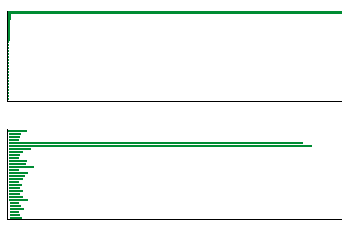

In [16]:
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
k = 1000
n_points = 1200
nbs = 800
sigma = 1500
movetimes = np.arange(len(sspikes[:,0]))
dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[:,:]), dim = dim)
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)    

plot_barcode(persistence['dgms'])    
plt.show()

############ Decode cocycles ################
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = persistence["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

num_neurons = len(sspikes[0,:])
centcosall = np.zeros((num_neurons, 2, n_points))
centsinall = np.zeros((num_neurons, 2, n_points))
dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)
    
dspk = preprocessing.scale(sspikes)

a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coords = np.arctan2(mtot2,mtot1)%(2*np.pi)

(-1.4902930983104414,
 51.47581346335624,
 -1.4671790623227385,
 51.58782073380345)

<Figure size 432x288 with 0 Axes>

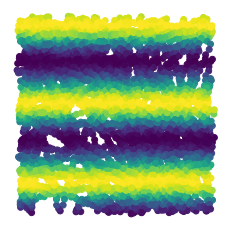

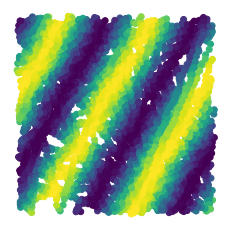

In [17]:
plt.viridis()
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coords[:,0]))
ax.set_aspect('equal', 'box')
plt.axis('off')
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coords[:,1]))
ax.set_aspect('equal', 'box')
plt.axis('off')


In [20]:
np.savez('Toroidal_topology_grid_cell_data/Results/guanella_data', sspikes = log_grid_cells)

## Couey

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: scipy.ravel is deprecated and will be removed in SciPy 2.0.0, use numpy.ravel instead
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: scipy.ravel is deprecated and will be removed in SciPy 2.0.0, use numpy.ravel instead
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: scipy.ravel is deprecated and will b

0.83 percent done
1.67 percent done
2.50 percent done
3.34 percent done
4.17 percent done
5.01 percent done
5.84 percent done
6.68 percent done
7.51 percent done
8.35 percent done
9.18 percent done
10.02 percent done
10.85 percent done
11.69 percent done
12.52 percent done
13.36 percent done
14.19 percent done
15.03 percent done
15.86 percent done
16.69 percent done
17.53 percent done
18.36 percent done
19.20 percent done
20.03 percent done
20.87 percent done
21.70 percent done
22.54 percent done
23.37 percent done
24.21 percent done
25.04 percent done
25.88 percent done
26.71 percent done
27.55 percent done
28.38 percent done
29.22 percent done
30.05 percent done
30.88 percent done
31.72 percent done
32.55 percent done
33.39 percent done
34.22 percent done
35.06 percent done
35.89 percent done
36.73 percent done
37.56 percent done
38.40 percent done
39.23 percent done
40.07 percent done
40.90 percent done
41.74 percent done
42.57 percent done
43.41 percent done
44.24 percent done
45.0

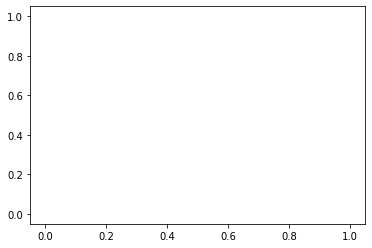

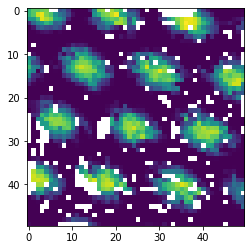

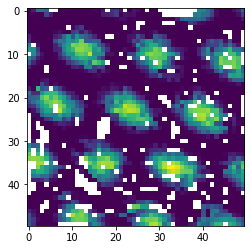

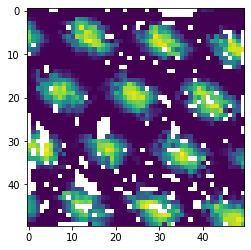

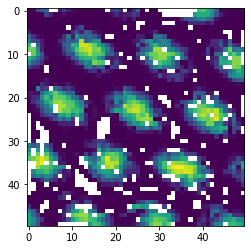

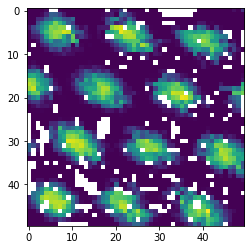

In [19]:
#### Couey
xx,yy,__,__ = load_pos('R','OF','day1',bSpeed = False)

dxx =  xx[:100000]#gaussian_filter1d(xx,10)
dyy =  yy[:100000]#gaussian_filter1d(yy,10)
speeds = np.zeros(len(dxx))
speeds[1:] =np.sqrt(np.square(dxx[1:]-dxx[:-1]) + np.square(dyy[1:]-dyy[:-1]))*1000
speeds[0] = speeds[1]
angs = np.zeros(len(dxx))
angs[1:] = np.arctan2(dyy[1:]-dyy[:-1],dxx[1:]-dxx[:-1])
angs[0] = angs[1]
posx = xx[np.arange(0,180000,2)]
posy = yy[np.arange(0,180000,2)]
post = np.arange(0,180000,2)/100
#xx,yy = xx[np.arange(0,15000,10)],yy[np.arange(0,15000,10)]
dxx =  xx[:100000]#gaussian_filter1d(xx,10)
dyy =  yy[:100000]#gaussian_filter1d(yy,10)
#dxx,dyy = dxx[np.arange(0,50000,1)],dyy[np.arange(0,50000,1)]
#num_steps = len(dxx)
speeds = np.zeros(len(dxx))
speeds[1:] =np.sqrt(np.square(dxx[1:]-dxx[:-1]) + np.square(dyy[1:]-dyy[:-1]))*1000
speeds[0] = speeds[1]
angs = np.zeros(len(dxx))
angs[1:] = np.arctan2(dyy[1:]-dyy[:-1],dxx[1:]-dxx[:-1])
angs[0] = angs[1]
posx = xx[np.arange(0,180000,2)]
posy = yy[np.arange(0,180000,2)]
post = np.arange(0,180000,2)/100
post = post[np.isfinite(posx)]
posy = posy[np.isfinite(posx)]
posx = posx[np.isfinite(posx)]
post = post[np.isfinite(posy)]
posx = posx[np.isfinite(posy)]
posy = posy[np.isfinite(posy)]
post *= 1000

side = max(max(posx)-min(posx), max(posy)-min(posy))
posx *= 1./side
posy *= 1./side
posx -= min(posx)
posy -= min(posy)

tnew = np.arange(0, 599000, 1)
posx = np.interp(tnew, post, posx)
posy = np.interp(tnew, post, posy)
post = tnew

#Get angles and velocities
angs = np.zeros(len(post))
angs[:-1] = np.arctan2(posy[1:]-posy[:-1], posx[1:]-posx[:-1])
angs[-1] = angs[-2]
speeds = 1000.*np.sqrt((posx[1:]-posx[:-1])**2+(posy[1:]-posy[:-1])**2)
nums = len(speeds)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from scipy import *
import scipy.io

numbumps = 4 
# parameters of the model
extinp = 1.
alpha = 0.15
ell = 2.
inh = -0.02
R  = 15.
Nx = 28
Ny = 44

if(numbumps==4):
    Nx*=2
if(numbumps==8):
    Nx*=2
    Ny*=2
NG=Nx*Ny 

### MAKE CONNECTIVITY WITH AN OFFSET RELATIVE TO PREFERRED DIRECTION
theta = zeros([Nx,Ny])
theta[0:Nx:2,0:Ny:2] = 0
theta[1:Nx:2,0:Ny:2] = 1
theta[0:Nx:2,1:Ny:2] = 2
theta[1:Nx:2,1:Ny:2] = 3
theta = 0.5*pi*theta
theta = ravel(theta)
xes = zeros([Nx,Ny])
yes = zeros([Nx,Ny])
for x in range(Nx):
    for y in range(Ny):
        xes[x,y] = x
        yes[x,y] = y
xes = ravel(xes)
yes = ravel(yes)
Rsqrd = R**2
W = zeros([NG,NG])
for xi in range(Nx):
    xdiffA = abs(xes-xi-ell*cos(theta))
    xdiffB = Nx-xdiffA
    xdiffA = xdiffA**2
    xdiffB = xdiffB**2
    for y in range(Ny):
        n = xi*Ny+y
        ydiffA = abs(yes-y-ell*sin(theta))
        ydiffB = Ny-ydiffA
        ydiffA = ydiffA**2
        ydiffB = ydiffB**2
        d = xdiffA+ydiffA
        W[d<Rsqrd,n] += inh
        d = xdiffB+ydiffA
        W[d<Rsqrd,n] += inh
        d = xdiffA+ydiffB
        W[d<Rsqrd,n] += inh
        d = xdiffB+ydiffB
        W[d<Rsqrd,n] += inh
xes=0
yes=0
N = NG

S = (rand(Nx*Ny) > 0.1)*1.0
for t in range(2000):
    S = S + 0.1*(-S + maximum((extinp+np.matmul(S,W)),0.))
    S[S<0.00001] = 0.

maxS = max(np.ravel(S))
minx = min([min(posy),min(posx)])
maxx = max([max(posy),max(posx)])
whichn = np.arange(len(S))#random.sample(np.arange(len(S)), 100)
nodes1 = np.zeros([len(whichn), nums])

fig = plt.figure(13)
plt.plot([],[],'-')
#print animation.writers.avail

for t in range(0, nums):
    S = S + 0.1*(-S + np.maximum((extinp+np.matmul(S,W)+alpha*speeds[t]*np.cos(angs[t]-theta)),0.))
    if(np.mod(t,10)==0):
        S[S<0.0001] = 0.
    nodes1[:,t] = S#[]#>0.3*maxS ##some fake spikes
    if(np.mod(t,5000)==0 and t>2):
        print('%2.2f percent done'%(float(t)*100/float(nums)))
from scipy.stats import binned_statistic_2d, pearsonr
num_neurons = len(nodes1[:,0])
inds = np.arange(num_neurons)
np.random.shuffle(inds)
for i in inds[:5]:
    mtot, x_edge, y_edge, circ = binned_statistic_2d(posx[:t],posy[:t], nodes1[i,:t], 
        statistic='mean', bins=50, range=None, expand_binnumbers=True)
    plt.figure()
    plt.imshow(mtot)

In [21]:
np.savez('Toroidal_topology_grid_cell_data/Results/couey_data', sspikes = nodes1)

In [35]:
sspikes = nodes1.T

In [42]:
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
k = 1000
n_points = 1200
nbs = 800
sigma = 1500

movetimes = np.arange(0, len(sspikes[:,0]), 40)
dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[:,:]), dim = dim)
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)    

plot_barcode(persistence['dgms'])    
plt.show()

############ Decode cocycles ################
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = persistence["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

num_neurons = len(sspikes[0,:])
centcosall = np.zeros((num_neurons, 2, n_points))
centsinall = np.zeros((num_neurons, 2, n_points))
dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)
    
dspk = preprocessing.scale(sspikes)

a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coords = np.arctan2(mtot2,mtot1)%(2*np.pi)

MemoryError: Unable to allocate 11.0 GiB for an array with shape (598999, 2464) and data type float64

In [ ]:
######## Square Torus ################ 

num_points = 2500
sspikes = np.zeros((num_points,4))
xx = np.zeros(num_points)
yy = np.zeros(num_points)
rot_mat = []
x,y = np.meshgrid(np.linspace(0,1, 52)[1:-1], np.linspace(0,1, 52)[1:-1])
x,y = np.meshgrid(np.linspace(0,1, int(np.sqrt(num_points))+2)[1:-1],  
                  np.linspace(0,1, int(np.sqrt(num_points))+2)[1:-1])
x = x.flatten()*2*np.pi
y = y.flatten()*2*np.pi
for n in range(num_points):
    u,v = x[n],y[n]
    u += np.random.rand()*0.05
    v += np.random.rand()*0.05   
    f1 = np.cos(u)
    f2 = np.sin(u)
    f3 = np.cos(v)
    f4 = np.sin(v)
    sspikes[n,:] = (f1,f2,f3,f4)
    xx[n] = u
    yy[n] = v


dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
num_neurons = len(sspikes[0,:])
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

dim_red_spikes_move_scaled = preprocessing.scale(sspikes[:,:])
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

############ Compute persistent homology ################
rips_real = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix = True)
plot_barcode(rips_real['dgms'])    

diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
call = np.zeros((num_circ, len(sspikes[:,0])))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)


for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)
centcosall = np.zeros((num_neurons, 2, 1200))
centsinall = np.zeros((num_neurons, 2, 1200))

dspk = preprocessing.scale(sspikes[indstemp,:])#[movetimes[indstemp],:])

k = 1200
for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

dspk = preprocessing.scale(sspikes)
a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))


mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coordsnew = np.arctan2(mtot2,mtot1)%(2*np.pi)
plt.viridis()
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coordsnew[:,0]))
ax.set_aspect('equal', 'box')
plt.axis('off')
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coordsnew[:,1]))
ax.set_aspect('equal', 'box')
plt.axis('off')


In [ ]:
######## Hexagonal Torus ################ 

a_1 = 1
a_2 = 1
b_3 = 1
b_1 = 1/np.sqrt(3)
b_2 = -1/np.sqrt(3)
#b_1 = np.sqrt(3)/2
#b_2 = -np.sqrt(3)/2
C_1 = 1
C_2 = 1
C_3 = 1
num_points = 2500
sspikes = np.zeros((num_points,6))
xx = np.zeros(num_points)
yy = np.zeros(num_points)
rot_mat = []
#x,y = np.meshgrid(np.linspace(0,1, 52)[1:-1], np.linspace(0,1, 52)[1:-1])
x,y = np.meshgrid(np.linspace(0,1, int(np.sqrt(num_points))+1)[:-1],  
                  np.linspace(0,1, int(np.sqrt(num_points))+1))
x = x.flatten()*2*np.pi
y = y.flatten()*2*np.pi
for n in range(num_points):
    u,v = x[n],y[n]
    u += np.random.rand()*0.1
    v += np.random.rand()*0.1    
    f1 = C_1 *np.cos(a_1*u + b_1*v)
    f2 = C_1 *np.sin(a_1*u + b_1*v)
    f3 = C_2 *np.cos(a_2*u + b_2*v)
    f4 = C_2 *np.sin(a_2*u + b_2*v)
    f5 = C_3 *np.cos(b_3*v)
    f6 = C_3 *np.sin(b_3*v)
    sspikes[n,:] = (f1,f2,f3,f4,f5,f6)
    xx[n] = u
    yy[n] = v


dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
num_neurons = len(sspikes[0,:])
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

dim_red_spikes_move_scaled = preprocessing.scale(sspikes[:,:])
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

############ Compute persistent homology ################
rips_real = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix = True)
plot_barcode(rips_real['dgms'])    

diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
call = np.zeros((num_circ, len(sspikes[:,0])))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)


for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)
centcosall = np.zeros((num_neurons, 2, 1200))
centsinall = np.zeros((num_neurons, 2, 1200))

dspk = preprocessing.scale(sspikes[indstemp,:])#[movetimes[indstemp],:])

k = 1200
for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

dspk = preprocessing.scale(sspikes)
a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))


mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coordsnew = np.arctan2(mtot2,mtot1)%(2*np.pi)
plt.viridis()
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coordsnew[:,0]))
ax.set_aspect('equal', 'box')
plt.axis('off')
plt.figure()
ax = plt.axes()
ax.scatter(xx, yy, c = np.cos(coordsnew[:,1]))
ax.set_aspect('equal', 'box')
plt.axis('off')
